In [1]:
from nltk.corpus import stopwords
import re
import spacy
import pandas as pd

stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


city_newsletter_re=re.compile(r'([A-Za-z\s]+)?\/?([A-Z\s]+)?(,?\s[A-za-z]+.+\s)?\(Reuters\)')
html_re=re.compile(r'<[^>]+>|&amp;|&lt;|&gt;|&nbsp;')
links_re=re.compile(r'http[s]?:\/\/\S+')
date_re=re.compile(r'(\b(January|February|March|April|May|June|July|August|September|October|November|December)\b\s\d{1,2},\s\d{4})',re.IGNORECASE)
username_re=re.compile(r'@\w+')
punctuation_re=re.compile(r'[^\w\s]')
image_reference=re.compile(r'(Featured|Photo\sby|Image)[\w\/\s]+',re.IGNORECASE)



def data_lemmatizing(text): 
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc]
)

def preprocess_data_fake_news(text):
    text=date_re.sub('',text)
    text=image_reference.sub('',text)
    text=html_re.sub('',text)
    text=username_re.sub('_USERNAME_TOKEN_',text)
    text=links_re.sub('_URL_TOKEN_',text)
    text=punctuation_re.sub('',text)
    return " ".join(w for w in text.split() if w.lower() not in stop_words)

def preprocess_data_true_news(text):
    text=city_newsletter_re.sub('',text, count=1)
    text=punctuation_re.sub('',text)
    return " ".join(w for w in text.split() if w.lower() not in stop_words)

def lower_text(text):
    return text.lower()

D:\github\AI-examples\AI_examples\.venv\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
from tqdm import tqdm

tqdm.pandas()


df_fake= pd.read_csv("data/fake.csv")
df_true= pd.read_csv("data/true.csv")

df_true.isna().sum()
df_true.drop_duplicates(inplace=True)
df_true.reset_index(drop=True, inplace=True)

df_fake["label"] = 0
df_true["label"] = 1

In [3]:
df_fake['cleaned_text'] = df_fake['text'].progress_apply(preprocess_data_fake_news)
df_fake['clean_text']=df_fake['cleaned_text'].progress_apply(data_lemmatizing)
df_fake['clean_text_lower']=df_fake['clean_text'].progress_apply(lower_text)

100%|██████████| 23481/23481 [00:00<00:00, 587029.06it/s]


In [4]:
df_true['cleaned_text'] = df_true['text'].progress_apply(preprocess_data_true_news)
df_true['clean_text'] = df_true['cleaned_text'].progress_apply(data_lemmatizing)
df_true['clean_text_lower']=df_true['clean_text'].progress_apply(lower_text)

100%|██████████| 21211/21211 [00:00<00:00, 558207.16it/s]


In [5]:
frames=[df_true,df_fake]
df=pd.concat(frames)
df.reset_index(drop=True,inplace=True)
df.drop_duplicates() #eliminam duplicatele
df = df.dropna(subset=["clean_text"]) #elimin valorile care au coloana clean_text nula
df = df.sample(frac = 1)#dam suffle la date
df.to_csv("data/fake_and_real_news_final.csv")

In [6]:
df.sample(3)

,title,text,subject,date,label,cleaned_text,clean_text,clean_text_lower
28767,Texas Gun Nuts Open Fire On Democratic Office...,The Houston Police Department and Texas Ranger...,News,"March 11, 2016",0,Houston Police Department Texas Rangers invest...,Houston Police Department Texas Rangers invest...,houston police department texas rangers invest...
10535,"Secret Service probing agent, photographer fig...",WASHINGTON (Reuters) - The Secret Service is i...,politicsNews,"March 1, 2016",1,Secret Service investigating incident presiden...,Secret Service investigate incident presidenti...,secret service investigate incident presidenti...
31678,NEW REPORT: OBAMAPHONE Program Stashed $9 BILL...,Who could forget the Obamaphone Lady from Cl...,politics,"Jul 5, 2017",0,could forget Obamaphone Lady Cleveland OH unas...,could forget Obamaphone Lady Cleveland OH unas...,could forget obamaphone lady cleveland oh unas...


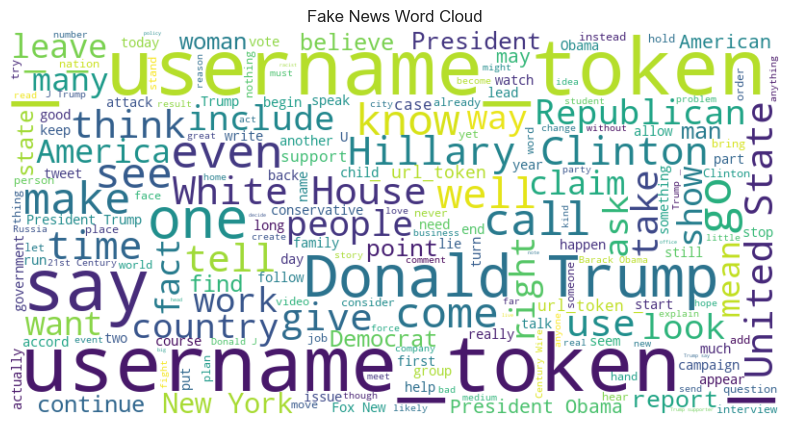

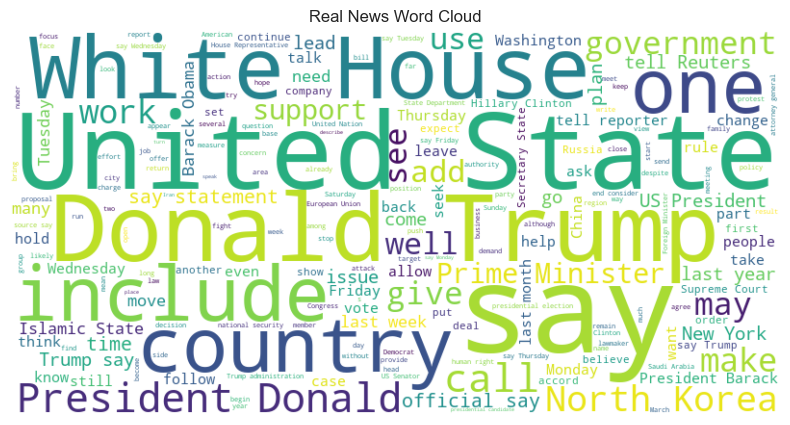

In [7]:
fake_news=df[df['label']==0]
real_news=df[df['label']==1]
text_fake_news = ' '.join(fake_news['clean_text'].astype(str).tolist())
text_real_news = ' '.join(real_news['clean_text'].astype(str).tolist())
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_fake_news)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("./diagrams/wc_fn.png")
plt.title("Fake News Word Cloud")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_real_news)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Real News Word Cloud")
plt.savefig("./diagrams/wc_rn.png")
plt.show()